In [89]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#Using NVIDIA Stock Data

In [90]:
df = yf.download('NVDA', start='2015-01-01', end='2024-01-01')
close_prices = df['Close'].values.reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


# Checking Stationarity

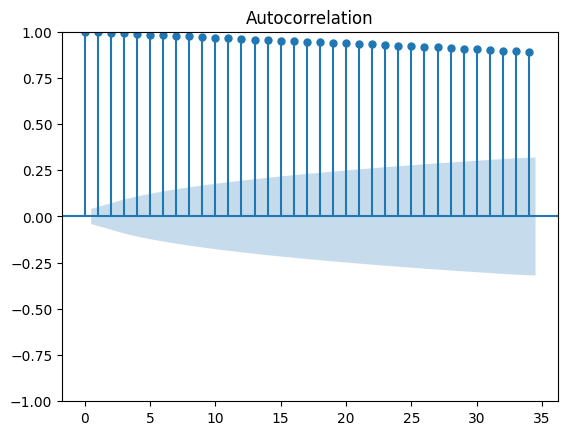

In [91]:
# Plotting ACF plot to choose value for MA

plot_acf(df.Close)
plt.show()

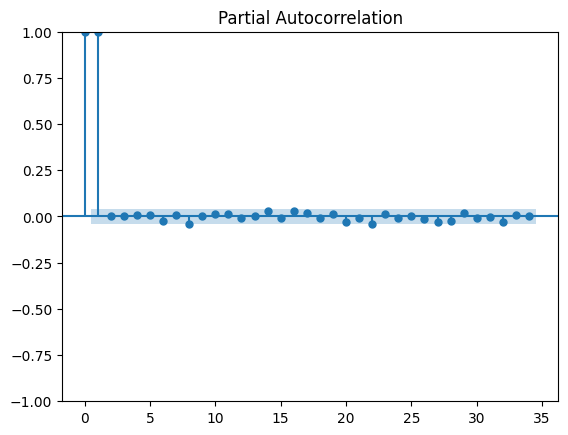

In [92]:
# Plotting PACF plot to choose value for AR

plot_pacf(df.Close)
plt.show()

#Train Test Split


In [99]:
# Step 2: Train-test split
train_size = int(len(close_prices) * 0.8)
train, test = close_prices[:train_size], close_prices[train_size:]

#Fitting ARIMA on Train

In [103]:
arima_model = ARIMA(train, order=(5, 1, 0))
arima_result = arima_model.fit()

In [104]:
# Step 4: Forecast on test length
arima_forecast = arima_result.forecast(steps=len(test))


# Calculating and Preparing Residuals for LSTM

In [105]:
residuals = test.flatten() - arima_forecast.flatten()


In [106]:
time_step = 30
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.reshape(-1, 1))

def create_dataset(seq, time_step):
    X, y = [], []
    for i in range(len(seq) - time_step):
        X.append(seq[i:i+time_step])
        y.append(seq[i+time_step])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_dataset(residuals_scaled, time_step)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

#LSTM Model

In [107]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_lstm, y_lstm, epochs=30, batch_size=32, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [108]:
lstm_pred_scaled = model.predict(X_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


In [109]:
arima_used = arima_forecast[time_step:]


# Hybrid Model Prediction

In [110]:
hybrid_pred = arima_used + lstm_pred.flatten()
actual = test[time_step:]

# Evaluation

In [111]:
r2 = r2_score(actual, hybrid_pred)
print(f"✅ Final Hybrid R² Score: {r2:.4f}")

✅ Final Hybrid R² Score: 0.9861


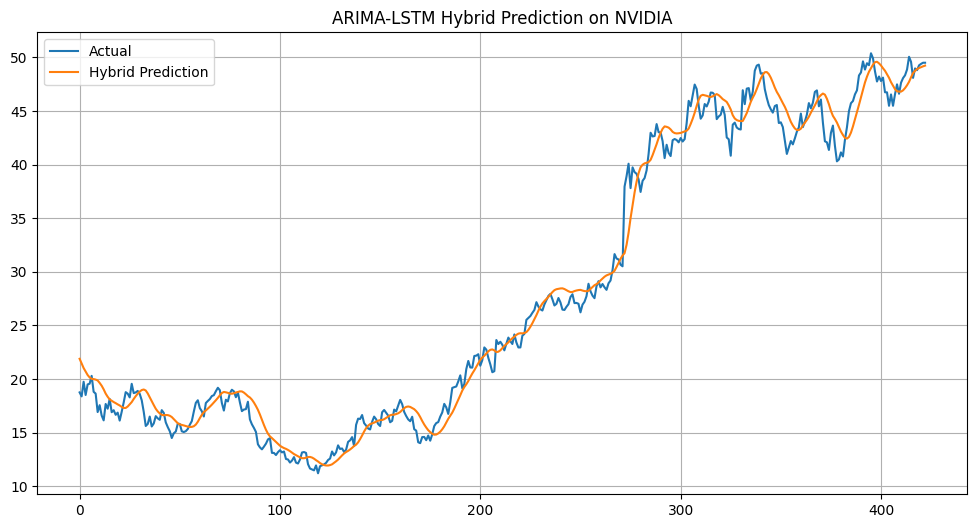

In [112]:
plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual')
plt.plot(hybrid_pred, label='Hybrid Prediction')
plt.title('ARIMA-LSTM Hybrid Prediction on NVIDIA')
plt.legend()
plt.grid()
plt.show()